### Solid Waste Engineering 2018
#### Book 2 of x see notebook Solid Waste Engineering 2018
#### Semester project: Testing the probability of garbage
Masters students in Environmental Engineering from the [École Polytechnique Féderale de Lausanne](https://enac.epfl.ch/environmental-engineering) test the hypothesis that litter densities on Lac Léman are predicatable.  The current method is based on the Probability Density Function derived from the logarithm of the pieces/meter of trash (pcs/m) from over 100 samples.

#### Purpose: Understanding how the results from one inventory relate to the rest of the inventories for the lake.

1. Getting data from the API
2. Reporting descriptive statistics
3. Comparing results on the lake
4. Graphing results

We will add to this workbook as the semester advances

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import re
from scipy.stats import norm
import scipy.stats
import statsmodels.api as sm
import seaborn
import requests
import json

### Get the data from the API
The api makes this operation very straight forward it can be put into a dataFrame directly.

In [2]:
# make a function to get data
# we will hit the api more than once
def getData(url):
    a = url
    c = requests.get(url).json()
    d = pd.DataFrame(c)
    return d

In [3]:
this_data = getData("http://mwshovel.pythonanywhere.com/dirt/daily-total/Lac-Léman/?format=json")
# the pcs/m ratio is not stored in the database and therefore needs to be calculated
this_data["pcs_m"]=this_data.total / this_data.length
# make a copy and give it a name that is easier to recognize:
dailyTotalsLac = this_data.copy()
colNameTotals = list(dailyTotalsLac.columns)
numSamps = len(dailyTotalsLac)
# one record from the df
#dailyTotalsLac.iloc[0]

#### This is all the beaches in the database for Lac Léman:
This gives all the geo information for each beach in the data base:

In [4]:
beach_data = getData("http://mwshovel.pythonanywhere.com/dirt/beaches/Lac-L%C3%A9man/")
beachData = beach_data.copy()
beachColumns = list(beachData.columns)
# one record from the df
#beachData.iloc[0]

#### Getting the object information for each inventory
The inventories are stored in a non aggregated form.

In [5]:
code_data = getData("https://mwshovel.pythonanywhere.com/dirt/codes/Lac-Léman/")
codeData = code_data.copy()
codeColumns = list(codeData.columns)
#codeData.iloc[0]

#### This gets the MLW codes from the website:

In [6]:
csvUrl = "https://mwshovel.pythonanywhere.com/static/newCriteria.csv"
mlwCodes = pd.read_csv(csvUrl)
#mlwCodes.iloc[0]

#### The descriptive statistics for each beach on the lake and for the lake
This data is available on the api also

In [7]:
# make a function to get all the results in a dictionary:
url_x = "http://mwshovel.pythonanywhere.com/dirt/summary" #<--- need to add the following "/beach or lake/?format=json"
beachNames = list(beachData.location)
cities = list(beachData.city.unique())

In [8]:
def getSummaries(aList):
    c = {}
    for x in aList:
        a = str(url_x + "/" + str(x) + "/?format=json")
        b = requests.get(a).json()
        d = {x:b}
        c.update(d)
    return c
beachSummaries = getSummaries(beachNames)
citySummaries = getSummaries(cities)
lakeSummary = getSummaries(['Lac-Léman'])

In [9]:
# so if that works we should be able to do something like this:
print(cities[3])
print(citySummaries[cities[3]])
# that looks good!

Tolochenaz
{'num_locs': 1, 'total': 402, 'num_samps': 1, 'first': '2016-04', 'last': '2016-04', 'ave_dense': '3.2683', 'max_dense': '3.2683', 'min_dense': '3.2683', 'two_five': '3.2683', 'seven_five': '3.2683', 'num_lakes': 1, 'num_rivers': 0, 'stan_dev': '0.0000', 'location': 'Tolochenaz'}


### Item comparisons

### How does the composition of items found at Tiger-duck-beach (TDB) compare to the previous results?

In [10]:
# code to count the number of MLW categories found: 
tDB = codeData.loc[codeData.location_id == "Tiger-duck-beach"].copy()
codesTDB = list(tDB.code_id)
numberOfCodes = len(codesTDB)
print("There were " + str(numberOfCodes) + " categories indentified at Tiger-duck-beach")

There were 30 categories indentified at Tiger-duck-beach


### Histogram of code counts from all inventories on the lake

Text(0.5, 1.0, 'Number of categories per survey n=147')

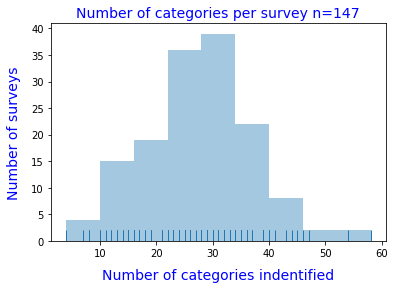

In [11]:
# code to make histogram:
codesGroupedDate = pd.DataFrame(codeData['quantity'].groupby([codeData['location_id'],codeData['date'], codeData['code_id']]).sum())
codeCounts = codesGroupedDate.groupby(['location_id', 'date']).count()
fig = plt.gcf()
g = seaborn.distplot(codeCounts, bins=9, kde=False, rug=True);
g.set_ylabel("Number of surveys", labelpad= 10, color='b', fontsize=14)
g.set_xlabel('Number of categories indentified', labelpad= 10, color='b', fontsize=14)
g.set_title("Number of categories per survey n=" + str(numSamps), color='b', fontsize=14)

#### Tiger-duck-beach had 30 different codes indentified.
#### So the number of categories indentified at Tiger-duck-beach is right around the 50th percentile for the lake.
### The breakdown of code counts per inventory, 147 inventories:

In [12]:
# The average number of codes identified per inventory:
codeCounts.describe()

,quantity
count,147.000000
mean,26.904762
std,9.482019
min,4.000000
25%,21.000000
50%,27.000000
75%,33.000000
max,58.000000


## If the number of categories was in the 50th percentile how do the catgegory results compare?

### Was there one item in particular that caused the extreme pcs/m value for the day ?

### Or was it a combination of many items ?

In [13]:
# get the codes in pieces per meter:
tDB['pcs_m'] = tDB.quantity/tDB.length
codeData['pcs_m']  = codeData.quantity/codeData.length
# reduce the data to only those codes indentified at TDB
tdBCodeData = codeData.loc[codeData.code_id.isin(codesTDB)]
# remove any values = 0 
tdBCodeData = tdBCodeData[tdBCodeData['pcs_m'] > 0]
# get the log of pcs_m, its a scale thing for charting
tdBCodeData['ln_pcs'] = np.log(tdBCodeData['pcs_m'])

In [14]:
# Select any records from TDB that are greater than the some percentile
def getGreaterThan(aList, p):
    c = []
    for b in aList:
        a = tdBCodeData.loc[tdBCodeData.code_id == b ][['location_id','code_id', 'pcs_m']]
        e = a.pcs_m.quantile(p)
        f = a[(a.location_id == "Tiger-duck-beach") & (a.pcs_m > e)]
        # grab the value that is greater than the desired %
        if len(f['pcs_m'].values) > 0:
            c.append((b,e,f['pcs_m'].values[0]))
    return c
# choose the seventy fifth etc..:
seventyFifth = getGreaterThan(codesTDB, .75)
ninetyFifth = getGreaterThan(codesTDB, .95)
ninetyNinth = getGreaterThan(codesTDB, .99)
print("There were " + str(len(seventyFifth)) + " categories greater than the 75th %,")
print("There were " + str(len(ninetyFifth)) + " categories greater than the 90th %,")
print("There were " + str(len(ninetyNinth)) + " categories greater than the 99th %.")

There were 25 categories greater than the 75th %,
There were 19 categories greater than the 90th %,
There were 9 categories greater than the 99th %.


### 25 of the 30 categories exceeded the 75th percentile for all previous samples on the lake.

There was a variety of objects that caused the extreme value. Looking at the 99th percentile and greater, there are nine categories that meet this criteria.

Lets take a look at those nine catgories:

In [15]:
# code to get the nine categories:
crazy99 = [x[0] for x in ninetyNinth]
print(crazy99)

['G24', 'G21', 'G32', 'G89', 'G93', 'G100', 'G137', 'G87', 'G79']


### Take a look at the boxplot of all results for those nine categories:

In [16]:
# first we need to get some colors for our charts:
import random
xkcd_colors = list(seaborn.xkcd_rgb.keys())
these_colors = random.sample(xkcd_colors, 34)
random_colors = seaborn.xkcd_palette(these_colors)

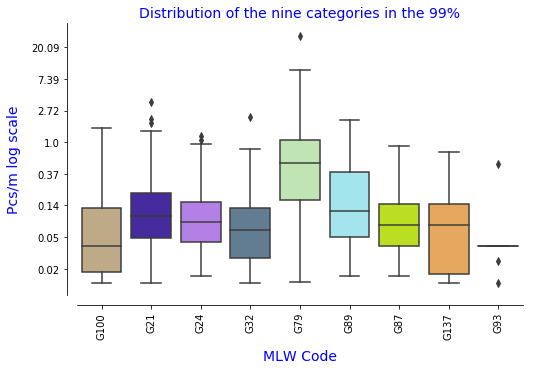

In [17]:
# code to make the chart:
theNinetyNine = tdBCodeData.loc[tdBCodeData.code_id.isin(crazy99)]
# use the log otherwise the scale is way out their
ax = seaborn.boxplot(x="code_id", y="ln_pcs", palette=random_colors, data=theNinetyNine)
fig = plt.gcf()
x_tick_labels = []
seaborn.despine(offset=10)
for label in ax.get_xticklabels():
    label.set_rotation(90)
for label in ax.get_yticks():
    label = round(np.exp(label), 2)
    x_tick_labels.append(label)
ax.set_yticklabels(x_tick_labels)
ax.set_ylabel("Pcs/m log scale", labelpad= 10, color='b', fontsize=14)
ax.set_xlabel('MLW Code', labelpad= 10, color='b', fontsize=14)
ax.set_title("Distribution of the nine categories in the 99%", color='b', fontsize=14)

fig.set_size_inches(8,5)
plt.show()

### Okay so what are those nine codes?

1. What industry are they from? Material type? Descritption?

In [18]:
# get the MLW description for the nine codes:
nineCodes = mlwCodes.loc[mlwCodes.code.isin(crazy99)]
for n, row in nineCodes.iterrows():
    thisRow = row[['code', 'description', 'material']].values
    print(str(thisRow[0]) + ": " + str(thisRow[1]) + ", " + str(thisRow[2]))

G21: Drink lids, Plastic
G24: Plastic rings from lids, Plastic
G32: Toys and fireworks, Plastic
G79: Plastic pieces 2.5 > < 50cm, Plastic
G87: Masking tape, Plastic
G89: Plastic construction waste, Plastic
G93: Cable ties , Plastic
G100: Medical containers, Plastic
G137: Clothing, rags, hats etc.,,, Cloth


### Sometimes the stripplot gives a better visual of the distribution

This is the same data as the box plots above

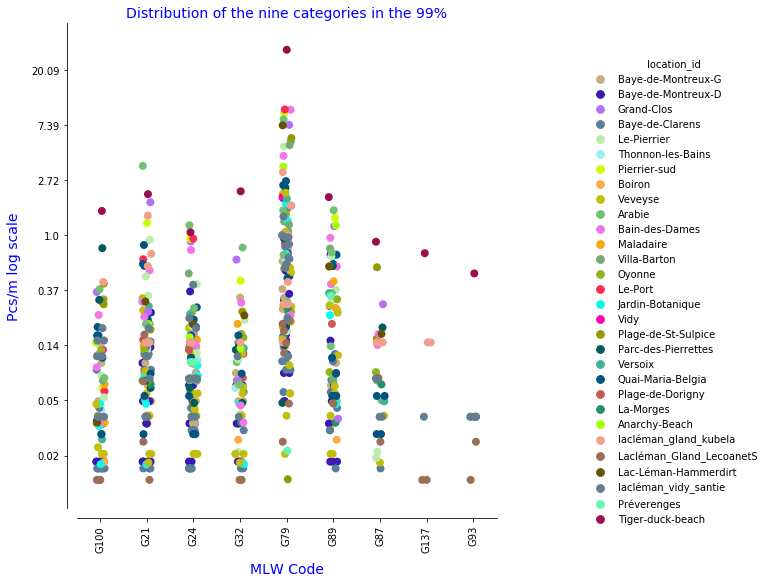

In [19]:
# call the seaborn plot
g = seaborn.catplot(x="code_id", y="ln_pcs", data=theNinetyNine, aspect=1,hue="location_id", s=8, palette=random_colors, legend_out=True,)
# set the figure
fig = plt.gcf()
# move the chart off the grid lines a little
seaborn.despine(offset=10)
# need to conver the y tick labels from log(x) to e^x
y_tick_labels = []
for ax in g.axes.flat:
    # rotate the xtick labels
    for label in ax.get_xticklabels():
        label.set_rotation(90)
    # convert the ytick labels
    for label in ax.get_yticks():
        label = round(np.exp(label), 2)
        y_tick_labels.append(label)
    ax.set_yticklabels(y_tick_labels)
# set the axis labels
g.ax.set_ylabel("Pcs/m log scale", labelpad= 10, color='b', fontsize=14)
g.ax.set_xlabel('MLW Code', labelpad= 10, color='b', fontsize=14)
g.ax.set_title("Distribution of the nine categories in the 99%", color='b', fontsize=14)
fig.set_size_inches(11, 8)
plt.show()


### Discussion:

The biggest change is from G79 -- "Plastic Pieces", and the presence of G93 -- "Cable ties". Apparently G93 had not been identified on the lake previously. This is not likeley and they were probably placed in another category like "Strapping bands".

Nonetheless Fragmented plastics make up almost 50% of the total pcs/m. In general on the lake fragmented plastics are about 12% of the total. 

### Take a look at how the pcs/m is distributed for all categories in the Tiger-duck-beach inventory:

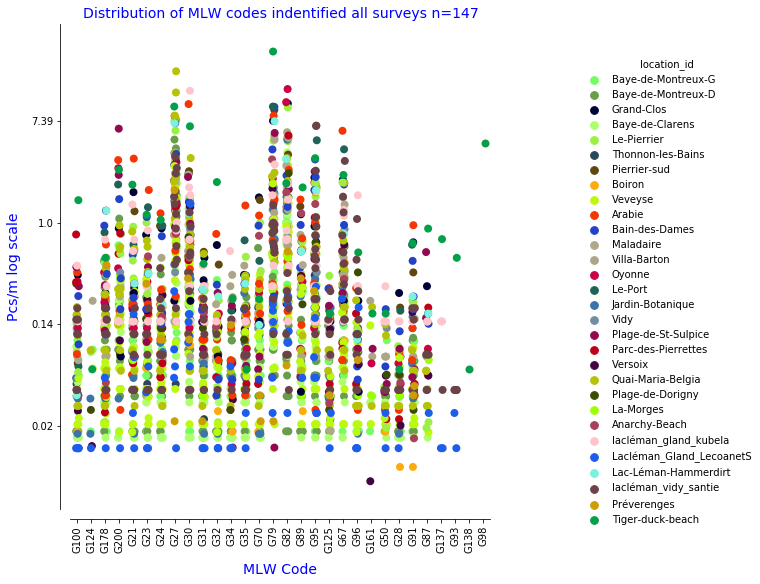

In [20]:
# code to make the chart:
these_colors = random.sample(xkcd_colors, 34)
random_colors = seaborn.xkcd_palette(these_colors)

g = seaborn.catplot(x="code_id", y="ln_pcs", data=tdBCodeData, aspect=1,hue="location_id", s=8, edgecolor="w", palette=random_colors, jitter=True, legend_out=True,)

fig = plt.gcf()
x_tick_labels = []

    
seaborn.despine(offset=10)
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(90)
    for label in ax.get_yticks():
        label = round(np.exp(label), 2)
        x_tick_labels.append(label)
    ax.set_yticklabels(x_tick_labels)
g.ax.set_ylabel("Pcs/m log scale", labelpad= 10, color='b', fontsize=14)
g.ax.set_xlabel('MLW Code', labelpad= 10, color='b', fontsize=14)
g.ax.set_title("Distribution of MLW codes indentified all surveys n=" + str(numSamps), color='b', fontsize=14)

fig.set_size_inches(11, 8)
plt.show()


### Media Filters -- rankings and quantity

In [21]:
# percentile ranking and frquency of media filters
G91 = codeData[codeData.code_id == "G91"].copy()
G91['POF']  = G91['pcs_m'].apply(lambda x: scipy.stats.percentileofscore(G91['pcs_m'], x, kind='weak'))
score = G91[G91.location_id == "Tiger-duck-beach"]["POF"]
found = G91[G91.location_id == "Tiger-duck-beach"]["quantity"]
numb = len(G91)

print("There were " + str(found.values[0]) + " media-filters found, or " + str(round(found.values[0]/18, 2)) + " pcs/m.")
print("The media filters pcs/m ranking at TDB is in the " + str(round(score.values[0], 0)) + " percentile of " + str(numb) + " samples.")
print("There are " + str(len(dailyTotalsLac)) + " samples currently in the data-base, so they are found about 50% of the time.")

There were 12 media-filters found, or 0.67 pcs/m.
The media filters pcs/m ranking at TDB is in the 97.0 percentile of 73 samples.
There are 147 samples currently in the data-base, so they are found about 50% of the time.


Text(0.5, 1.0, 'Media-filters indentified all surveys n=73')

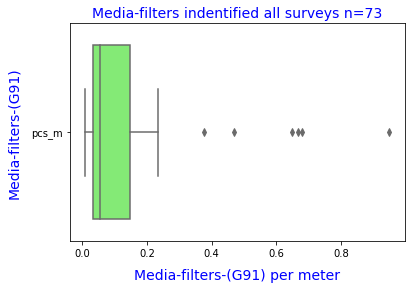

In [22]:
# boxplot code
ax = seaborn.boxplot( palette=random_colors, orient='h', data=G91[["pcs_m", "code_id"]])
ax.set_xlabel("Media-filters-(G91) per meter", labelpad= 10, color='b', fontsize=14)
ax.set_ylabel("Media-filters-(G91)", labelpad= 10, color='b', fontsize=14)
ax.set_title("Media-filters indentified all surveys n=" + str(numb), color='b', fontsize=14)


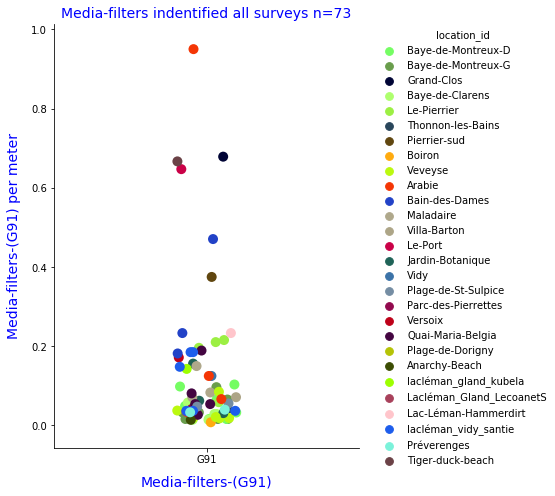

In [23]:
# dist plot code
g = seaborn.catplot(x="code_id", y="pcs_m", data=G91, aspect=1,hue="location_id", palette=random_colors, s=10, legend_out=True,)
fig = plt.gcf()
fig.set_size_inches(8, 7)
g.ax.set_ylabel("Media-filters-(G91) per meter", labelpad= 10, color='b', fontsize=14)
g.ax.set_xlabel("Media-filters-(G91)", labelpad= 10, color='b', fontsize=14)
g.ax.set_title("Media-filters indentified all surveys n=" + str(numb), color='b', fontsize=14)

plt.show()

In [24]:
# fig, ax = plt.subplots(figsize=(8, 5))
# ax.scatter(G91['date'].values, G91['pcs_m'].values, s=60, facecolor='b', edgecolor='w', )

# for label in ax.get_xticklabels():
#     label.set_rotation(90)
# ax.set(xlabel='MLW Code', ylabel='Pcs/m ')

# plt.show()